In [178]:
# import required modules
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

In [179]:
from torch.utils.data import Dataset, DataLoader

In [180]:
rating_df = pd.read_csv('ratings.csv')


In [181]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [182]:
df=rating_df

In [183]:
enc_movie = {movie_id: idx for idx, movie_id in enumerate(df["movieId"].unique())}
df["movieId"] = [enc_movie[movie_id] for movie_id in df["movieId"]]
print(f"movieId is from {df['movieId'].min()} to {df['movieId'].max()}")

enc_user = {user_id: idx for idx, user_id in enumerate(df["userId"].unique())}
df["userId"] = [enc_user[user_id] for user_id in df["userId"]]
print(f"userId is from {df['userId'].min()} to {df['userId'].max()}")

movieId is from 0 to 9723
userId is from 0 to 609


In [184]:
df

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931
...,...,...,...,...
100831,609,3120,4.0,1493848402
100832,609,2035,5.0,1493850091
100833,609,3121,5.0,1494273047
100834,609,1392,5.0,1493846352


In [185]:
# ttsplit
train, test = train_test_split(rating_df, test_size=0.2, random_state=42)

In [186]:
class MF(nn.Module):
    def __init__(self, n_user, n_item, k=10):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(n_user, k)
        self.item_emb = nn.Embedding(n_item, k)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        # cosine similarity from user and item embeddings
        return (user_emb * item_emb).sum(1)


In [187]:
num_users = rating_df['userId'].nunique()
num_movies = rating_df['movieId'].nunique()
print(num_users, num_movies)

610 9724


In [188]:
def train_epocs(model,epochs=30,lr=0.01,wd=0.0):
    train_loss = []
    test_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    for i in range(epochs):
        model.train()
        users = Tensor(train['userId'].values).long()
        movies = Tensor(train['movieId'].values).long()
        ratings = Tensor(train['rating'].values)

        y_hat = model.forward(users, movies)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        testloss=valid_loss(model)
        train_loss.append(loss.item())
        test_loss.append(testloss)
        print('train loss:',loss.item(),'test loss:',testloss)
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train_loss','test_loss'])
    # label the axes
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [189]:
def valid_loss(model):
    model.eval()
    users = Tensor(test['userId'].values).long()
    movies = Tensor(test['movieId'].values).long()
    ratings = Tensor(test['rating'].values)
    y_hat = model.forward(users, movies)
    loss = F.mse_loss(y_hat, ratings)
    # print('valid loss:',loss.item())
    return loss.item()

In [190]:
model=MF(num_users,num_movies,100)

train loss: 12.916452407836914 test loss: 12.714374542236328
train loss: 12.727855682373047 test loss: 12.499724388122559
train loss: 12.506821632385254 test loss: 12.25468635559082
train loss: 12.253950119018555 test loss: 11.979826927185059
train loss: 11.969842910766602 test loss: 11.675771713256836
train loss: 11.655169486999512 test loss: 11.343262672424316
train loss: 11.310713768005371 test loss: 10.983200073242188
train loss: 10.937419891357422 test loss: 10.5966796875
train loss: 10.5364408493042 test loss: 10.185037612915039


train loss: 10.109169960021973 test loss: 9.749884605407715
train loss: 9.6572847366333 test loss: 9.29313850402832
train loss: 9.182778358459473 test loss: 8.817052841186523
train loss: 8.68798542022705 test loss: 8.32424545288086
train loss: 8.175610542297363 test loss: 7.817707061767578
train loss: 7.6487555503845215 test loss: 7.3008246421813965
train loss: 7.110934734344482 test loss: 6.777393341064453
train loss: 6.5660810470581055 test loss: 6.2516188621521
train loss: 6.0185441970825195 test loss: 5.728098392486572
train loss: 5.473073482513428 test loss: 5.211789131164551
train loss: 4.934784889221191 test loss: 4.707958221435547
train loss: 4.409111499786377 test loss: 4.222100257873535
train loss: 3.9017186164855957 test loss: 3.759836196899414
train loss: 3.4183907508850098 test loss: 3.3267621994018555
train loss: 2.9648776054382324 test loss: 2.9282634258270264
train loss: 2.546698570251465 test loss: 2.569274663925171
train loss: 2.168900728225708 test loss: 2.2540097236

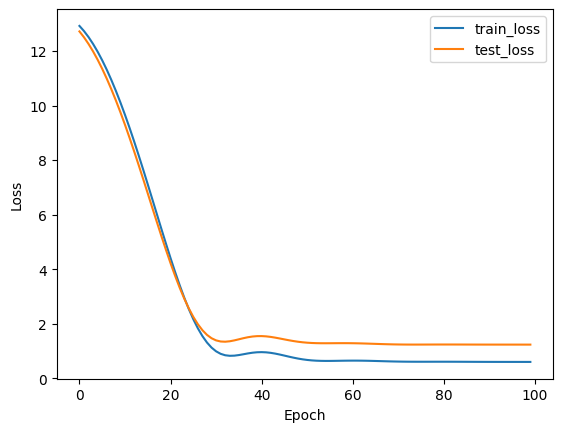

In [191]:
train_epocs(model,epochs=100,lr=0.005,wd=1e-7)

In [192]:
# pridicting for a single user
user=Tensor([0]).long()
movies=Tensor(range(num_movies)).long()
y_hat=model.forward(user,movies)
y_hat


tensor([4.5969, 3.7608, 4.7336,  ..., 3.3550, 3.9494, 3.9544],
       grad_fn=<SumBackward1>)

In [193]:
len(y_hat)

9724

In [194]:
# top 10 movies for user 0
top10=torch.topk(y_hat,10)
top10

torch.return_types.topk(
values=tensor([8.8704, 8.8661, 8.8621, 8.8487, 8.1892, 8.1889, 8.1641, 7.9916, 7.4529,
        7.3875], grad_fn=<TopkBackward0>),
indices=tensor([ 281,  280,  285, 6542,  288,  282, 8872, 5031, 6951, 8672]))